# Model development with fewer features

In this notebook, we are going to get the models best params with our data optimized with less features. For this, we need to load our base dataset (data_base.pkl) and the features from folder best_features.

In [2]:
#--------------------------Utilities---------------------#
from custom_class.customClass import ModelParams, ModelDevelopment
import pickle
import pandas as pd
import os

#--------------------------Models---------------------#
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC
import warnings

#------------------------Visualization---------------------#
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


#----------Settings----------#
%matplotlib inline
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 500)



Loading the 100 best features discovered by the logistic regression model

In [3]:
best_features = pd.read_csv('best_features/LogisticRegression_100.csv', sep=',')
cols = best_features.values.reshape(-1).tolist()
best_features[:10] 

,0
0,home_rolling_fg
1,home_rolling_fg%
2,home_rolling_3p
3,home_rolling_3p%
4,home_rolling_ft
5,home_rolling_ft%
6,home_rolling_trb
7,home_rolling_ast
8,home_rolling_pts
9,home_rolling_efg%


Loading our dataset and plugigng in our new columns

In [4]:
data_base = pickle.load(open('data_base.pkl', 'rb'))
X = data_base[cols]
y = data_base['home_win']

#print the shape of the data
print('X shape: ', X.shape)
print('y shape: ', y.shape)
X.head()

X shape:  (2027, 100)
y shape:  (2027,)


,home_rolling_fg,home_rolling_fg%,home_rolling_3p,home_rolling_3p%,home_rolling_ft,home_rolling_ft%,home_rolling_trb,home_rolling_ast,home_rolling_pts,home_rolling_efg%,home_rolling_trb%,home_rolling_drtg,home_rolling_fg_max,home_rolling_3p_max,home_rolling_ft_max,home_rolling_fta_max,home_rolling_ft%_max,home_rolling_orb_max,home_rolling_drb_max,home_rolling_trb_max,home_rolling_blk_max,home_rolling_+/-_max,home_rolling_drtg_max,home_rolling_Total,home_rolling_opponent_fg,home_rolling_opponent_3pa,home_rolling_opponent_ft,home_rolling_opponent_ft%,home_rolling_opponent_drb,home_rolling_opponent_ast,home_rolling_opponent_blk,home_rolling_opponent_tov,home_rolling_opponent_ts%,home_rolling_opponent_efg%,home_rolling_opponent_trb%,home_rolling_opponent_blk%,home_rolling_opponent_ortg,home_rolling_opponent_drtg,home_rolling_opponent_drb_max,home_rolling_opponent_blk_max,home_rolling_opponent_tov_max,home_rolling_opponent_+/-_max,home_rolling_opponent_orb%_max,home_rolling_opponent_drb%_max,home_rolling_opponent_ast%_max,home_rolling_opponent_stl%_max,home_rolling_opponent_Total,away_rolling_fg%,away_rolling_ast,away_rolling_stl,away_rolling_tov,away_rolling_pts,away_rolling_efg%,away_rolling_trb%,away_rolling_stl%,away_rolling_blk%,away_rolling_tov%,away_rolling_ortg,away_rolling_drtg,away_rolling_fg_max,away_rolling_3p%_max,away_rolling_ft_max,away_rolling_fta_max,away_rolling_drb_max,away_rolling_trb_max,away_rolling_stl_max,away_rolling_tov_max,away_rolling_+/-_max,away_rolling_ftr_max,away_rolling_drtg_max,away_rolling_Total,away_rolling_opponent_fg,away_rolling_opponent_fg%,away_rolling_opponent_3pa,away_rolling_opponent_3p%,away_rolling_opponent_ft,away_rolling_opponent_fta,away_rolling_opponent_drb,away_rolling_opponent_trb,away_rolling_opponent_ast,away_rolling_opponent_tov,away_rolling_opponent_pts,away_rolling_opponent_efg%,away_rolling_opponent_trb%,away_rolling_opponent_tov%,away_rolling_opponent_ortg,away_rolling_opponent_drtg,away_rolling_opponent_fg%_max,away_rolling_opponent_3p%_max,away_rolling_opponent_ft_max,away_rolling_opponent_fta_max,away_rolling_opponent_stl_max,away_rolling_opponent_blk_max,away_rolling_opponent_tov_max,away_rolling_opponent_pf_max,away_rolling_opponent_+/-_max,away_rolling_opponent_efg%_max,away_rolling_opponent_ast%_max,away_rolling_opponent_drtg_max,away_rolling_opponent_Total
0,44.000000,0.510333,12.166667,0.380833,17.666667,0.760667,45.833333,24.833333,117.833333,0.580833,53.483333,111.283333,9.833333,3.666667,5.833333,7.833333,1.000000,4.000000,8.500000,10.666667,2.666667,17.000000,118.166667,117.833333,42.500000,35.666667,14.166667,0.814333,31.333333,24.500000,4.000000,11.500000,0.561000,0.531000,46.533333,7.283333,111.283333,117.100000,6.666667,1.500000,4.166667,9.500000,20.766667,34.666667,48.316667,6.150000,111.666667,0.481500,26.333333,7.333333,15.000000,115.666667,0.550500,50.333333,7.116667,7.283333,13.116667,113.083333,116.500000,10.000000,0.766833,5.666667,6.666667,9.500000,11.333333,3.000000,4.000000,11.000000,1.349833,123.500000,115.666667,41.333333,0.478500,38.000000,0.401167,21.500000,28.000000,33.500000,42.500000,25.500000,13.833333,119.333333,0.566000,49.666667,12.266667,116.500000,113.083333,0.790500,0.902833,8.666667,11.000000,2.666667,2.333333,4.166667,4.666667,13.000000,1.000667,43.016667,121.000000,119.333333
1,45.166667,0.509833,16.666667,0.423667,15.833333,0.729833,48.333333,27.000000,122.833333,0.604500,52.850000,104.733333,11.500000,4.166667,7.166667,11.666667,1.000000,2.833333,9.333333,10.833333,1.833333,20.000000,114.333333,122.833333,39.666667,38.500000,15.333333,0.785000,33.166667,21.000000,5.333333,12.166667,0.524500,0.489667,47.166667,10.816667,104.733333,119.200000,9.000000,2.333333,3.666667,4.833333,20.450000,37.366667,54.933333,13.033333,107.666667,0.425167,20.833333,8.833333,14.500000,92.666667,0.477667,47.216667,9.450000,7.416667,13.483333,98.633333,107.816667,10.166667,0.721500,3.333333,5.000000,11.000000,15.166667,3.000000,5.666667,8.333333,0.649

Allright! Now we are going to do exactly waht we did in notebook 03, but with a subset of features. Our goal is to see if improve the accuracy of logistic regression and linear svc models, and if stops our ensemble to overfit and still get good results.

Now, we are going to save the model and their instances in a new folder, model_2. We also are going to include in the model name, the number of features it used to be created with that especif set of best parameters.

In [5]:
# reusing our model creation function with diferent paths
#creating a function that uses the ModelParams class to instantiates the model, its parameters and its respective scaler. Then, it instantiates the ModelDevelopment class and 
#uses the grid_search function to find the best parameters for the model.
def instantiate_best_model(model: object, X, y, scoring, path, n_features, scaler=True, random_search=False):
        """ Info:
                returns the model tunned with the best parameters
            -------------------------------------------------
             Input:
                model: Model to be tested
                X: Feature set
                y: Target series
                scoring: Metric to be optimized
                path: Path to save the model
                scaler: Whether to use a scaler or not
                random_search: Whether to use random search or not
                n_features: Number of features used in the model training
             ------------------------------------------------
             Output:
               best_model: Best model found by the grid search
               best_params: Best parameters found by the grid search
               best_score: Best score found by the grid search """
        
        # Using the ModelParams class to instantiate the model, its parameters and its respective scaler
        model_params = ModelParams(model, n_features, scaler)
        pipe, params, model_name = model_params.get_pipe()
        #checking if the model is already saved in the models folder
        # if the model is not saved, we instantiate the ModelDevelopment class and use the grid_search function to find the best parameters for the model and then save it
        if scaler:
                if not os.path.exists(path+model_name+'_'+str(n_features)+'.pkl'): 
                         # Using the ModelDevelopment class to instantiate the model
                        clf_instance = ModelDevelopment(pipe, model_name, X, y)
                        # Using the search function to find the best parameters for the model
                        if random_search:
                                best_model, *_  = clf_instance.random_search(params, scoring)
                        else:
                                best_model, *_  = clf_instance.grid_search(params, scoring) # This also fits the model instance with a variety of parameters against the dataset
                        #saving best model with best parameters to pickle file:
                        file_name = path+model_name+'_'+str(n_features)+'.pkl'
                        instance_name = path+model_name+'_'+str(n_features)+'_instance.pkl'
                        with open(file_name, 'wb') as f:
                                pickle.dump(best_model, f)
                        with open(instance_name, 'wb') as f:
                                pickle.dump(clf_instance, f) 
                else:
                        print('Model already saved')
                        pass
                       
        else:
                if not os.path.exists(path+model_name+'_'+str(n_features)+'_unscaled.pkl'):
                         # Using the ModelDevelopment class to instantiate the model
                        clf_instance = ModelDevelopment(pipe, model_name, X, y)
                        # Using the grid_search function to find the best parameters for the model
                        if random_search:
                                best_model, *_  = clf_instance.random_search(params, scoring)
                        else:
                                best_model, *_  = clf_instance.grid_search(params, scoring) # This also fits the model instance with a variety of parameters against the dataset
                        #saving best model with best parameters to pickle file:
                        file_name = path+model_name+'_'+str(n_features)+'_unscaled.pkl'
                        instance_name = path+model_name+'_'+str(n_features)+'_unscaled_instance.pkl'
                        with open(file_name, 'wb') as f:
                                pickle.dump(best_model, f)
                        with open(instance_name, 'wb') as f:
                                pickle.dump(clf_instance, f) 
                else:
                        print('Model already saved')
                        pass     

# Trying to find the best parameters models given the 100 best features found by logistic regression

Logistic Regression

In [6]:
# instantiating the best model for logistic regression
instantiate_best_model(LogisticRegression(random_state=42), X, y, 'roc_auc', 'models_2/', scaler=True, random_search=False, n_features=X.shape[1])

Model already saved


Accuracy: 76.6%
Precision: 77.0%
Recall: 82.7%
F1: 79.7%
AUC: 75.8%


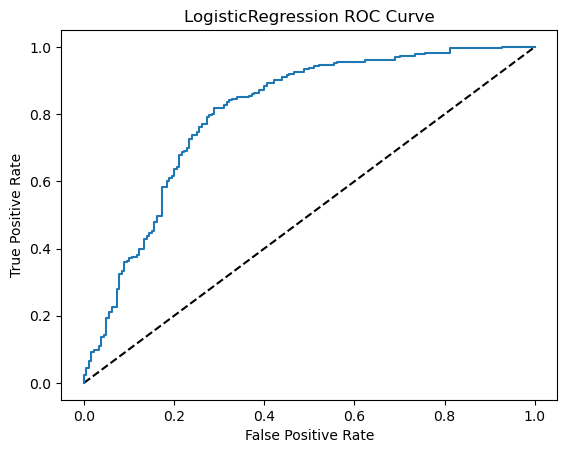

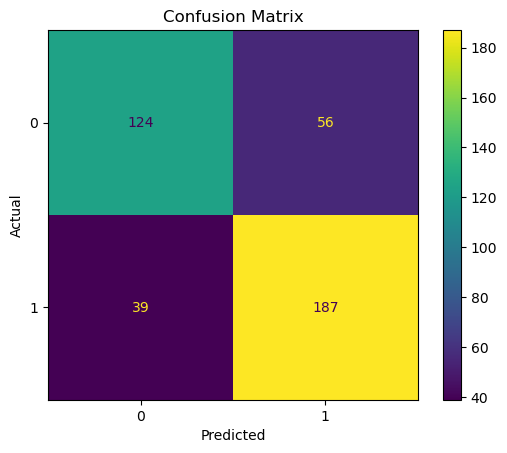

In [7]:
LR_instance = pickle.load(open('models_2/LogisticRegression_100_instance.pkl', 'rb'))

#ploting metrics
LR_instance.model_metrics()
LR_instance.roc_curve()
LR_instance.plot_confusion_matrix()


In [8]:
LR_instance.best_params

{'logisticregression__C': 0.001,
 'logisticregression__max_iter': 10000,
 'logisticregression__penalty': 'l2',
 'logisticregression__solver': 'newton-cg'}

The model did worst that the model trained with all the features. Was ROC 76.1% and now 75.8%

Linear SVC

In [9]:
# instantiating the best model for linear SVC
instantiate_best_model(LinearSVC(random_state=42), X, y, 'roc_auc', 'models_2/', scaler=True, random_search=False, n_features=X.shape[1])

Model already saved


Accuracy: 75.1%
Precision: 78.0%
Recall: 77.0%
F1: 77.5%
AUC: 74.9%


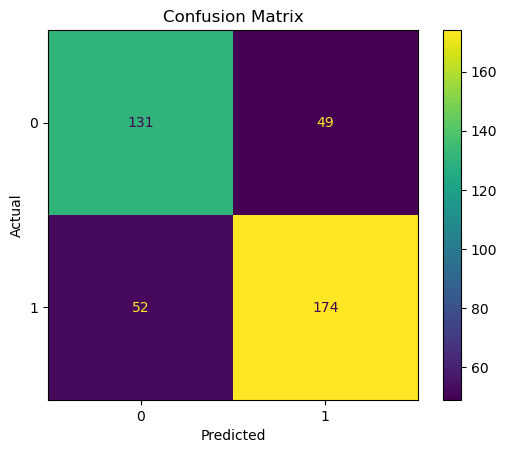

In [10]:
SVM_instance = pickle.load(open('models_2/LinearSVC_100_instance.pkl', 'rb'))
SVM_instance.model_metrics()
SVM_instance.plot_confusion_matrix()

In [11]:
#model best params
SVM_instance.best_params

{'linearsvc__C': 0.0001,
 'linearsvc__loss': 'squared_hinge',
 'linearsvc__max_iter': 100000}

ROC 0.1% better than with all features dataset.

Random Forest

In [12]:
# instantiating the best model for random forest
instantiate_best_model(RandomForestClassifier(random_state=42), X, y, 'roc_auc', 'models_2/', scaler=True, random_search=True, n_features=X.shape[1])

Model already saved


Accuracy: 90.4%
Precision: 88.2%
Recall: 95.6%
F1: 91.7%
AUC: 89.7%


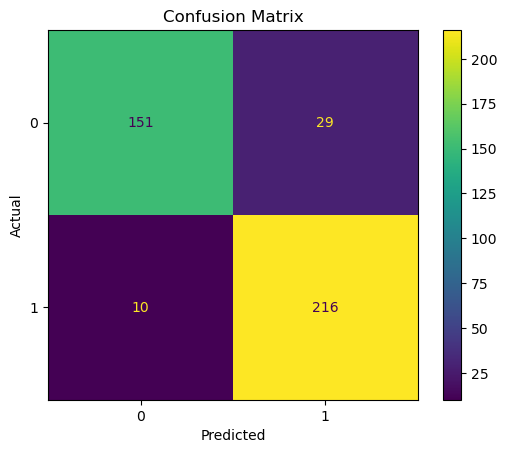

In [13]:
forest_instance = pickle.load(open('models_2/RandomForestClassifier_100_instance.pkl', 'rb'))
forest_instance.model_metrics()
forest_instance.plot_confusion_matrix()

In [14]:
forest_instance.best_params

{'randomforestclassifier__n_estimators': 1500,
 'randomforestclassifier__min_weight_fraction_leaf': 0.0,
 'randomforestclassifier__min_samples_split': 5,
 'randomforestclassifier__min_samples_leaf': 2,
 'randomforestclassifier__min_impurity_decrease': 0.0,
 'randomforestclassifier__max_leaf_nodes': 91,
 'randomforestclassifier__max_features': 'sqrt',
 'randomforestclassifier__max_depth': 9,
 'randomforestclassifier__criterion': 'entropy'}

Gradient boosting

In [15]:
# instantiating the best model for gradient boosting
instantiate_best_model(GradientBoostingClassifier(random_state=42), X, y, 'roc_auc', 'models_2/', scaler=True, random_search=True, n_features=X.shape[1])

Model already saved


Accuracy: 97.8%
Precision: 96.6%
Recall: 99.6%
F1: 98.0%
AUC: 97.6%


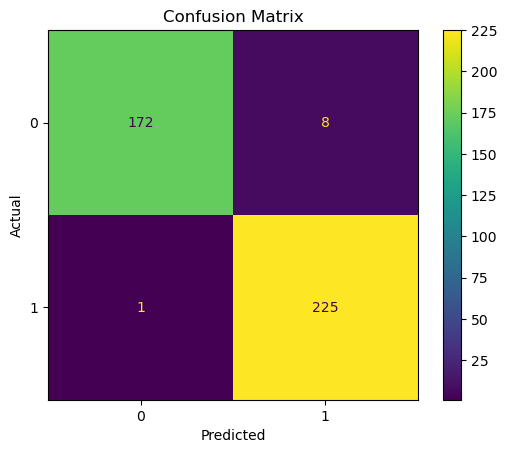

In [16]:
gb_instance = pickle.load(open('models_2/GradientBoostingClassifier_100_instance.pkl', 'rb'))
gb_instance.model_metrics()
gb_instance.plot_confusion_matrix()

Overfitted.

# Trying to find the best parameters models given the 50best features found by logistic regression

In [17]:
best_features = pd.read_csv('best_features/LogisticRegression_50.csv', sep=',')
cols = best_features.values.reshape(-1).tolist()
best_features.head() 

,0
0,home_rolling_ft
1,home_rolling_drb
2,home_rolling_pts
3,home_rolling_orb%
4,home_rolling_ast%


Loading our dataset and plugigng in our new columns

In [18]:
data_base = pickle.load(open('data_base.pkl', 'rb'))
X = data_base[cols]
y = data_base['home_win']

#print the shape of the data
print('X shape: ', X.shape)
print('y shape: ', y.shape)
X.head()

X shape:  (2027, 50)
y shape:  (2027,)


,home_rolling_ft,home_rolling_drb,home_rolling_pts,home_rolling_orb%,home_rolling_ast%,home_rolling_trb_max,home_rolling_pts_max,home_rolling_+/-_max,home_rolling_drb%_max,home_rolling_tov%_max,home_rolling_ortg_max,home_rolling_Total,home_rolling_opponent_3pa,home_rolling_opponent_tov,home_rolling_opponent_pts,home_rolling_opponent_blk%,home_rolling_opponent_pts_max,home_rolling_opponent_orb%_max,home_rolling_opponent_drb%_max,home_rolling_opponent_ast%_max,home_rolling_opponent_stl%_max,home_rolling_opponent_usg%_max,home_rolling_opponent_ortg_max,home_rolling_opponent_drtg_max,home_rolling_opponent_Total,away_rolling_fta,away_rolling_fta_max,away_rolling_trb_max,away_rolling_pts_max,away_rolling_+/-_max,away_rolling_drb%_max,away_rolling_trb%_max,away_rolling_ast%_max,away_rolling_stl%_max,away_rolling_blk%_max,away_rolling_drtg_max,away_rolling_Total,away_rolling_opponent_3pa,away_rolling_opponent_drb%,away_rolling_opponent_blk%,away_rolling_opponent_tov%,away_rolling_opponent_usg%,away_rolling_opponent_drtg,away_rolling_opponent_fta_max,away_rolling_opponent_+/-_max,away_rolling_opponent_ast%_max,away_rolling_opponent_stl%_max,away_rolling_opponent_tov%_max,away_rolling_opponent_drtg_max,away_rolling_opponent_Total
0,17.666667,36.666667,117.833333,22.550000,55.900000,10.666667,25.666667,17.000000,45.183333,57.866667,221.666667,117.833333,35.666667,11.500000,111.666667,7.283333,28.666667,20.766667,34.666667,48.316667,6.150000,36.066667,181.833333,125.500000,111.666667,20.666667,6.666667,11.333333,27.000000,11.000000,36.816667,24.683333,36.083333,5.200000,10.333333,123.500000,115.666667,38.000000,79.766667,8.783333,12.266667,100.0,113.083333,11.000000,13.000000,43.016667,5.083333,47.266667,121.000000,119.333333
1,15.833333,39.666667,122.833333,20.750000,59.916667,10.833333,31.666667,20.000000,30.983333,56.400000,186.166667,122.833333,38.500000,12.166667,107.666667,10.816667,24.666667,20.450000,37.366667,54.933333,13.033333,35.333333,217.166667,126.333333,107.666667,18.500000,5.000000,15.166667,24.666667,8.333333,42.566667,31.016667,31.683333,6.416667,12.500000,118.166667,92.666667,32.833333,75.450000,7.950000,15.433333,100.0,98.633333,5.833333,16.500000,48.700000,7.500000,56.333333,109.500000,101.333333
2,19.333333,37.833333,121.833333,18.883333,58.950000,12.500000,30.666667,12.000000,42.350000,48.583333,207.666667,121.833333,36.166667,12.166667,118.666667,6.450000,27.666667,13.166667,46.283333,35.366667,5.550000,34.816667,192.500000,123.500000,118.666667,21.000000,7.500000,10.333333,23.000000,12.833333,34.883333,20.216667,38.700000,5.466667,6.883333,112.500000,108.000000,31.166667,85.916667,5.783333,10.216667,100.0,107.116667,8.166667,9.000000,60.833333,5.333333,47.533333,113.166667,106.500000
3,19.000000,37.166667,115.666667,18.366667,65.683333,8.166667,32.000000,16.333333,37.233333,50.483333,196.333333,115.666667,37.333333,13.833333,111.500000,10.083333,25.833333,22.366667,40.666667,45.516667,5.250000,38.266667,206.666667,121.000000,111.500000,22.000000,8.500000,10.166667,28.166667,11.166667,32.900000,18.900000,35.700000,6.883333,16.416667,123.500000,114.500000,37.166667,76.183333,13.900000,11.983333,100.0,115.133333,10.166667,12.833333,48.866667,5.050000,56.100000,123.166667,115.166667
4,19.833333,34.666667,120.333333,20.583333,61.233333,11.166667,30.166667,12.333333,40.816667,47.150000,233.500000,120.333333,33.000000,12.333333,122.166667,5.166667,27.666667,20.000000,42.900000,38.483333,3.416667,32.950000,162.500000,122.166667,122.166667,17.000000,6.666667,11.166667,27.000000,12.333333,36.233333,25.866667,44.516667,4.683333,6.466667,119.000000,110.500000,28.666667,83.766667,7.383333,11.333333,100.0,114.066667,7.333333,9.166667,40.816667,4.550000,38.566667,119.833333,108.166667


Logistic Regression

In [19]:
# instantiating the best model for logistic regression
instantiate_best_model(LogisticRegression(random_state=42), X, y, 'roc_auc', 'models_2/', scaler=True, random_search=False, n_features=X.shape[1])

Model already saved


Accuracy: 76.4%
Precision: 78.3%
Recall: 79.6%
F1: 78.9%
AUC: 75.9%


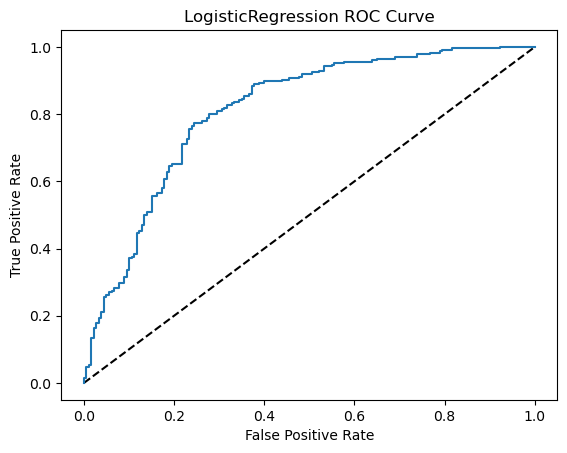

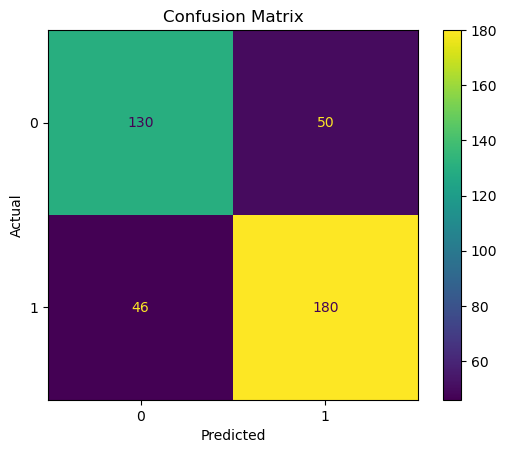

In [20]:
LR_instance = pickle.load(open('models_2/LogisticRegression_50_instance.pkl', 'rb'))

#ploting metrics
LR_instance.model_metrics()
LR_instance.roc_curve()
LR_instance.plot_confusion_matrix()

In [21]:
LR_instance.best_params

{'logisticregression__C': 0.01,
 'logisticregression__max_iter': 10000,
 'logisticregression__penalty': 'l2',
 'logisticregression__solver': 'liblinear'}

Only 0.01% increase from the model with the 100 features. This indicates a important insight: We lost almost no information by using less features! Keep in mind that the logist regression model was not overfitting, but our esemble were. Less features is what we want so the ensemble models dont overfit! We will try later with more features and much more data , from other seasons, but for now let keep the project with these dataset.

Linear SVC

In [22]:
# instantiating the best model for linear SVC
instantiate_best_model(LinearSVC(random_state=42), X, y, 'roc_auc', 'models_2/', scaler=True, random_search=False, n_features=X.shape[1])


Model already saved


Accuracy: 76.4%
Precision: 78.3%
Recall: 79.6%
F1: 78.9%
AUC: 75.9%


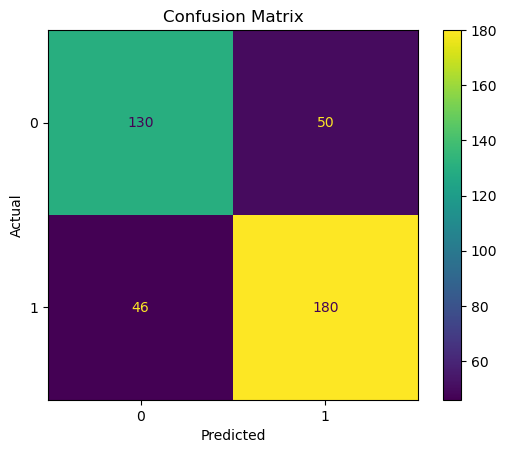

In [23]:
SVM_instance = pickle.load(open('models_2/LinearSVC_50_instance.pkl', 'rb'))
SVM_instance.model_metrics()
SVM_instance.plot_confusion_matrix()

In [24]:
#model best params
SVM_instance.best_params

{'linearsvc__C': 0.001,
 'linearsvc__loss': 'squared_hinge',
 'linearsvc__max_iter': 100000}

1% increase on accuraccy compared with 100 features. The model kept the same parameters as before.

Random Forest

In [25]:
# instantiating the best model for random forest
instantiate_best_model(RandomForestClassifier(random_state=42), X, y, 'roc_auc', 'models_2/', scaler=True, random_search=True, n_features=X.shape[1])

Model already saved


Accuracy: 82.5%
Precision: 81.9%
Recall: 88.1%
F1: 84.9%
AUC: 81.8%


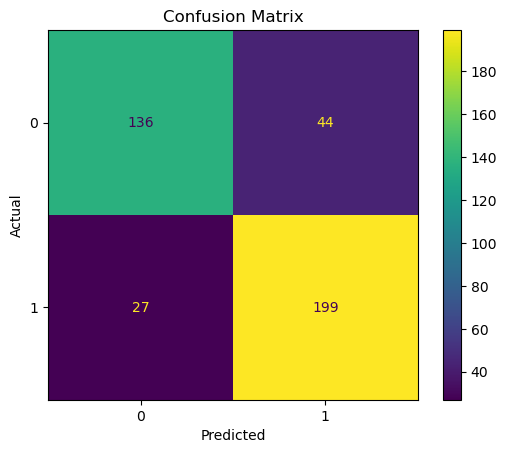

In [26]:
forest_instance = pickle.load(open('models_2/RandomForestClassifier_50_instance.pkl', 'rb'))
forest_instance.model_metrics()
forest_instance.plot_confusion_matrix()

In [27]:
forest_instance.best_params

{'randomforestclassifier__n_estimators': 1000,
 'randomforestclassifier__min_weight_fraction_leaf': 0.0,
 'randomforestclassifier__min_samples_split': 10,
 'randomforestclassifier__min_samples_leaf': 2,
 'randomforestclassifier__min_impurity_decrease': 0.0,
 'randomforestclassifier__max_leaf_nodes': 31,
 'randomforestclassifier__max_features': 'sqrt',
 'randomforestclassifier__max_depth': 7,
 'randomforestclassifier__criterion': 'entropy'}

Gradient boosting

In [28]:
# instantiating the best model for gradient boosting
instantiate_best_model(GradientBoostingClassifier(random_state=42), X, y, 'roc_auc', 'models_2/', scaler=True, random_search=True, n_features=X.shape[1])

Model already saved


Accuracy: 81.3%
Precision: 81.2%
Recall: 86.3%
F1: 83.7%
AUC: 80.6%


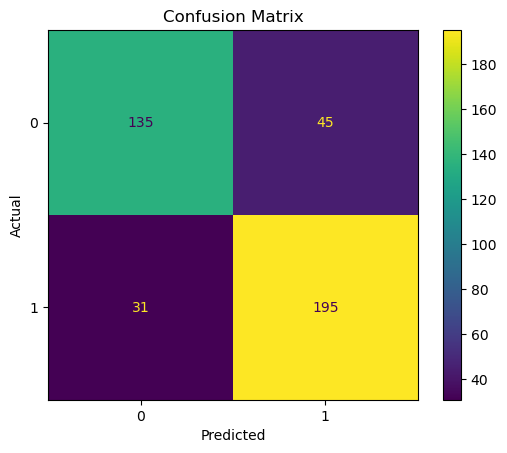

In [29]:
gb_instance = pickle.load(open('models_2/GradientBoostingClassifier_50_instance.pkl', 'rb'))
gb_instance.model_metrics()
gb_instance.plot_confusion_matrix()

In [30]:
gb_instance.best_params

{'gradientboostingclassifier__subsample': 0.3,
 'gradientboostingclassifier__n_estimators': 500,
 'gradientboostingclassifier__min_weight_fraction_leaf': 0.0,
 'gradientboostingclassifier__min_samples_split': 5,
 'gradientboostingclassifier__min_samples_leaf': 2,
 'gradientboostingclassifier__min_impurity_decrease': 0.0,
 'gradientboostingclassifier__max_leaf_nodes': 31,
 'gradientboostingclassifier__max_features': 'sqrt',
 'gradientboostingclassifier__max_depth': 3,
 'gradientboostingclassifier__loss': 'deviance',
 'gradientboostingclassifier__learning_rate': 0.01,
 'gradientboostingclassifier__criterion': 'squared_error'}